# 주식채권현금 평균모멘텀스코어 분산투자 미국 그림 2-35
- 투자기간 : 2003년 8월~2017년 6월
- 투자 대상 : 미국 S&P500지수SPY, 미국 10년 만기 국채, 20년 만기 국채TLT, 현금SHY
- 매수 규칙 : 주식 : 채권 : 현금 = S&P500지수 최근 12개월 평균 모멘텀 스코어 : 10년 (20년) 만기 국고채 지수 최근 12 개월 평균 모멘텀 스코어: 1
- 매도 규칙 : 매달 말 위의 투자 비중을 새로 계산하여 주식 :채권 : 현금 투자 비중을 조절하여 반복
- SPY 8.6%/-50.8%
- SPY+IEF+SHY : 5.5%/-4.3%
- SPY+TLT+SHY : 6.2%/-8.5%

In [1]:
from settings import *

## 데이타 읽기

In [2]:
tickers = ['SPY', 'SHY', 'IEF', 'TLT']
read_df = yf.download(tickers)['Adj Close']
read_df = read_df[tickers]
read_df.info()

[*********************100%***********************]  4 of 4 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7304 entries, 1993-01-29 to 2022-01-28
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     7304 non-null   float64
 1   SHY     4911 non-null   float64
 2   IEF     4911 non-null   float64
 3   TLT     4911 non-null   float64
dtypes: float64(4)
memory usage: 285.3 KB


In [3]:
for c in read_df.columns:
    print(c, read_df[c].first_valid_index())

SPY 1993-01-29 00:00:00
SHY 2002-07-30 00:00:00
IEF 2002-07-30 00:00:00
TLT 2002-07-30 00:00:00


In [4]:
data = read_df.dropna().copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4911 entries, 2002-07-30 to 2022-01-28
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     4911 non-null   float64
 1   SHY     4911 non-null   float64
 2   IEF     4911 non-null   float64
 3   TLT     4911 non-null   float64
dtypes: float64(4)
memory usage: 191.8 KB


## 전략 Class 생성

In [5]:
# 월말에 계산하고 다음월 첫 거래일 종가로 거래 한다고 전재
# 12개월 평균모멘텀스코어 계산

class WeighAMS(bt.Algo):
    def __init__(self, lags, months):
        super(WeighAMS, self).__init__()
        self.lags = lags
        self.months = months

    def 평균모멘텀스코어(self, 데이터, 개월):
        초기값 = 0
        for i in range(1, 개월+1):
            초기값 += np.where(데이터 / 데이터.shift(i) > 1, 1, 0)
        return 초기값[-1]/개월

    def AMS(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        average_momentum_score = pd.Series(dtype='float64')
        # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        t0 = (target.now - pd.DateOffset(months=self.lags)).strftime("%Y-%m")
        start = (target.now - pd.DateOffset(months=self.lags) - pd.DateOffset(months=self.months)).strftime("%Y-%m")

        print(f"\nprc : {target.now} {t0} ~ {start}")
        prc = target.universe[selected].loc[start:t0].resample('M').last()
        if (len(prc) < self.months+1):
            return False

        weights = pd.Series(self.AMS(prc), index=selected)
        weights = weights/weights.sum()

#         print(self.평균모멘텀스코어(prc, self.months), prc)
        target.temp['weights'] = weights

        return True

## 전략 생성

In [6]:
# 매월 초 
# lags 1은 한달 전  ~ 13개월전 평균 모멘텀 스코어
def average_momentum_score_strategy(name, data, tickers, lags=1, months=12):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=False, #월초
                                run_on_last_date=False),
            bt.algos.SelectThese(tickers),
            WeighAMS(lags, months), # lags=0이면 위와 같다.
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)

## 전략 실행

In [7]:
bt_spy = long_only_ew(data, ['SPY'], 'SPY')
bt_10 = average_momentum_score_strategy('SPY+IEF+SHY', data, ['SPY', 'SHY', 'IEF'])
bt_20 = average_momentum_score_strategy('SPY+TLT+SHY', data, ['SPY', 'SHY', 'TLT'])

r10 = bt.run(bt_10)


prc : 2002-07-30 00:00:00 2002-06 ~ 2001-06

prc : 2002-08-01 00:00:00 2002-07 ~ 2001-07

prc : 2002-09-03 00:00:00 2002-08 ~ 2001-08

prc : 2002-10-01 00:00:00 2002-09 ~ 2001-09

prc : 2002-11-01 00:00:00 2002-10 ~ 2001-10

prc : 2002-12-02 00:00:00 2002-11 ~ 2001-11

prc : 2003-01-02 00:00:00 2002-12 ~ 2001-12

prc : 2003-02-03 00:00:00 2003-01 ~ 2002-01

prc : 2003-03-03 00:00:00 2003-02 ~ 2002-02

prc : 2003-04-01 00:00:00 2003-03 ~ 2002-03

prc : 2003-05-01 00:00:00 2003-04 ~ 2002-04

prc : 2003-06-02 00:00:00 2003-05 ~ 2002-05

prc : 2003-07-01 00:00:00 2003-06 ~ 2002-06

prc : 2003-08-01 00:00:00 2003-07 ~ 2002-07
2003-08-01 00:00:00 SPY+IEF+SHY SPY:0.462 SHY:0.385 IEF:0.154 

prc : 2003-09-02 00:00:00 2003-08 ~ 2002-08
2003-09-02 00:00:00 SPY+IEF+SHY SPY:0.480 SHY:0.320 IEF:0.200 

prc : 2003-10-01 00:00:00 2003-09 ~ 2002-09
2003-10-01 00:00:00 SPY+IEF+SHY SPY:0.324 SHY:0.353 IEF:0.324 

prc : 2003-11-03 00:00:00 2003-10 ~ 2002-10
2003-11-03 00:00:00 SPY+IEF+SHY SPY:0.387 SHY:

In [10]:
r20 = bt.run(bt_20)
r_spy = bt.run(bt_spy)
r = bt.run(bt_10, bt_20, bt_spy)


prc : 2002-07-30 00:00:00 2002-06 ~ 2001-06

prc : 2002-08-01 00:00:00 2002-07 ~ 2001-07

prc : 2002-09-03 00:00:00 2002-08 ~ 2001-08

prc : 2002-10-01 00:00:00 2002-09 ~ 2001-09

prc : 2002-11-01 00:00:00 2002-10 ~ 2001-10

prc : 2002-12-02 00:00:00 2002-11 ~ 2001-11

prc : 2003-01-02 00:00:00 2002-12 ~ 2001-12

prc : 2003-02-03 00:00:00 2003-01 ~ 2002-01

prc : 2003-03-03 00:00:00 2003-02 ~ 2002-02

prc : 2003-04-01 00:00:00 2003-03 ~ 2002-03

prc : 2003-05-01 00:00:00 2003-04 ~ 2002-04

prc : 2003-06-02 00:00:00 2003-05 ~ 2002-05

prc : 2003-07-01 00:00:00 2003-06 ~ 2002-06

prc : 2003-08-01 00:00:00 2003-07 ~ 2002-07
2003-08-01 00:00:00 SPY+TLT+SHY SPY:0.500 SHY:0.417 TLT:0.083 

prc : 2003-09-02 00:00:00 2003-08 ~ 2002-08
2003-09-02 00:00:00 SPY+TLT+SHY SPY:0.500 SHY:0.333 TLT:0.167 

prc : 2003-10-01 00:00:00 2003-09 ~ 2002-09
2003-10-01 00:00:00 SPY+TLT+SHY SPY:0.333 SHY:0.364 TLT:0.303 

prc : 2003-11-03 00:00:00 2003-10 ~ 2002-10
2003-11-03 00:00:00 SPY+TLT+SHY SPY:0.444 SHY:

In [11]:
start = '2003-08-01'
e = '2017-6-30'

In [12]:
r.set_date_range(start)
r.display()

Stat                 SPY+IEF+SHY    SPY+TLT+SHY    SPY
-------------------  -------------  -------------  ----------
Start                2003-08-01     2003-08-01     2003-08-01
End                  2022-01-28     2022-01-28     2022-01-28
Risk-free rate       0.00%          0.00%          0.00%

Total Return         194.44%        222.15%        543.04%
Daily Sharpe         1.07           1.02           0.63
Daily Sortino        1.67           1.64           0.97
CAGR                 6.01%          6.53%          10.59%
Max Drawdown         -9.00%         -11.89%        -55.19%
Calmar Ratio         0.67           0.55           0.19

MTD                  -5.15%         -5.65%         -6.95%
3m                   -3.16%         -3.85%         -3.23%
6m                   -0.38%         -1.15%         1.39%
YTD                  -5.15%         -5.65%         -6.95%
1Y                   10.61%         10.39%         18.59%
3Y (ann.)            9.48%          10.96%         20.79%
5Y (ann.)

In [13]:
r.set_date_range(start, e)
r.display()

Stat                 SPY+IEF+SHY    SPY+TLT+SHY    SPY
-------------------  -------------  -------------  ----------
Start                2003-08-01     2003-08-01     2003-08-01
End                  2017-06-30     2017-06-30     2017-06-30
Risk-free rate       0.00%          0.00%          0.00%

Total Return         117.52%        135.74%        224.98%
Daily Sharpe         1.20           1.07           0.55
Daily Sortino        2.00           1.79           0.86
CAGR                 5.74%          6.36%          8.84%
Max Drawdown         -8.71%         -11.89%        -55.19%
Calmar Ratio         0.66           0.53           0.16

MTD                  0.18%          0.46%          0.64%
3m                   1.72%          2.36%          2.83%
6m                   5.88%          6.64%          9.17%
YTD                  5.88%          6.64%          9.17%
1Y                   7.11%          5.54%          17.77%
3Y (ann.)            2.70%          3.37%          9.51%
5Y (ann.)     

In [15]:
r.prices.resample('MS').first().to_drawdown_series().describe()

,SPY+IEF+SHY,SPY+TLT+SHY,SPY
count,167.000,167.000,167.000
mean,-0.008,-0.014,-0.072
std,0.013,0.022,0.116
min,-0.061,-0.090,-0.529
25%,-0.011,-0.021,-0.090
50%,0.000,-0.002,-0.014
75%,0.000,0.000,0.000
max,0.000,0.000,0.000


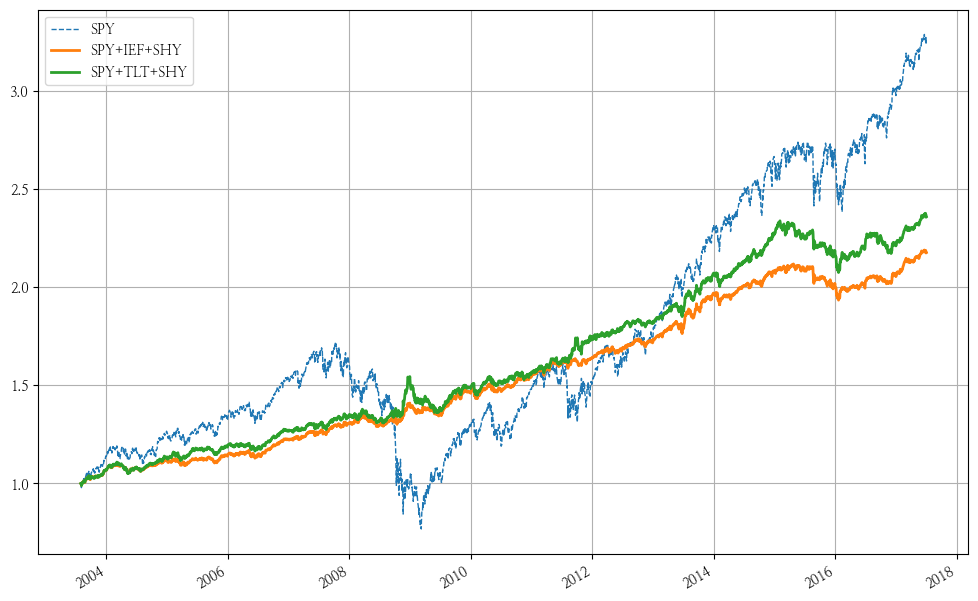

In [16]:
r_spy.set_date_range(start,e)
r10.set_date_range(start,e)
r20.set_date_range(start,e)

ax1 = r_spy.prices['2003-8-1':'2017-6'].rebase(1).plot(ls='--', figsize=(12, 8));
r10.prices['2003-8-1':'2017-6'].rebase(1).plot(ax=ax1, lw=2, figsize=(12, 8));
r20.prices['2003-8-1':'2017-6'].rebase(1).plot(ax=ax1, lw=2, figsize=(12, 8));

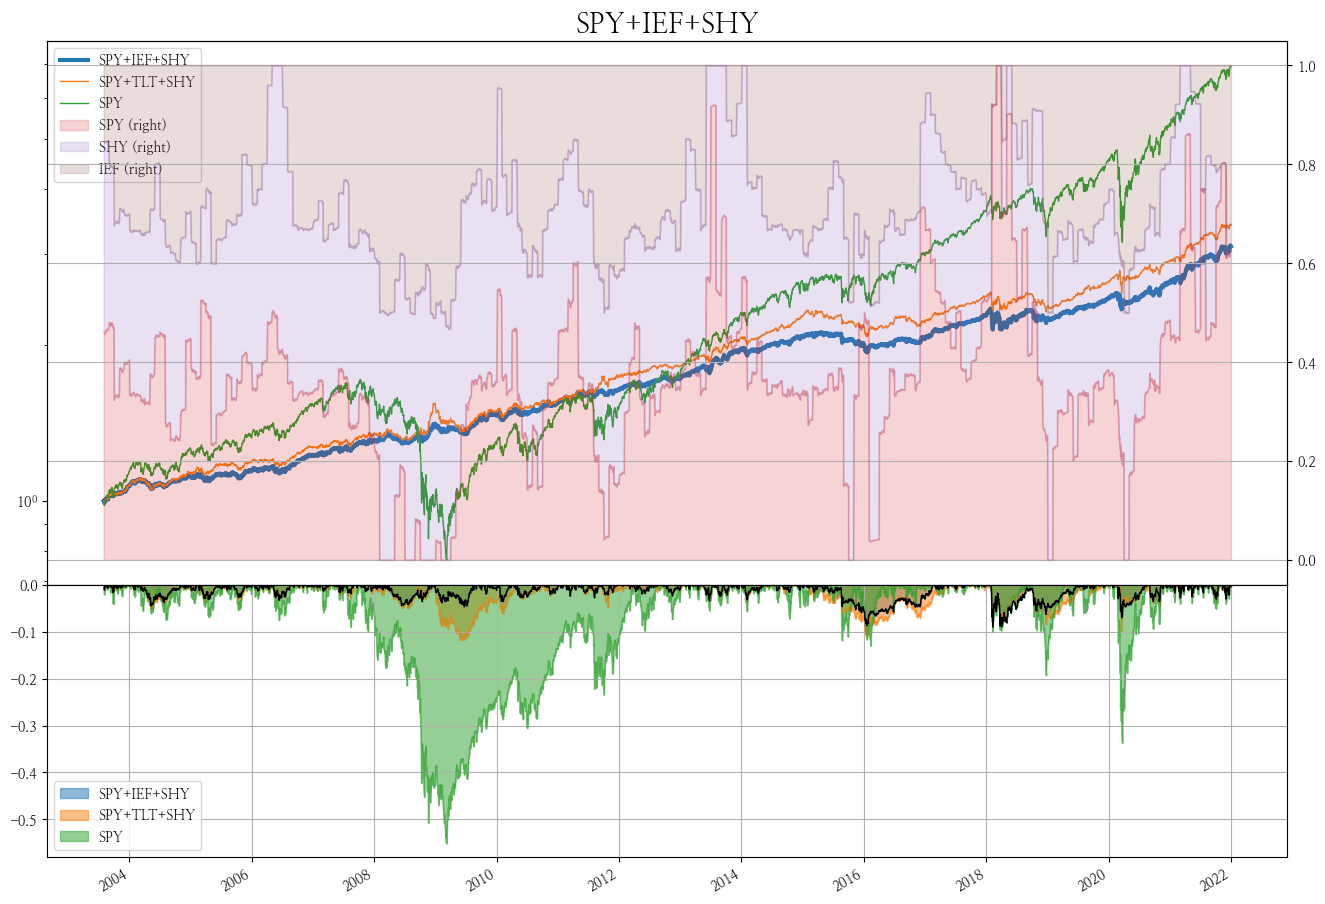

In [17]:
r_all = bt.run(bt_10, bt_20, bt_spy)
r_all.set_date_range(start)
plot_assets(r_all, start, '2021', 'SPY+IEF+SHY')